# EDA

## 데이터 확인
data 에 있는 파일을 random 9(3x3)개 씩 확인해 보기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

In [2]:
# CSV 파일 경로
train_csv_path = '../data/train_correct_labeling.csv'
meta_csv_path = '../data/meta.csv'

# 데이터 폴더 경로
image_folder_path = '../data/train/'

# CSV 파일 읽기
train_df = pd.read_csv(train_csv_path)
meta_df = pd.read_csv(meta_csv_path)

In [3]:
# 데이터 구조 확인
print("Train CSV Columns:", train_df.columns)
print("Meta CSV Columns:", meta_df.columns)

# 예시 데이터 확인
print("Train Data Sample:\n", train_df.head())
print("Meta Data Sample:\n", meta_df.head())

Train CSV Columns: Index(['ID', 'target'], dtype='object')
Meta CSV Columns: Index(['target', 'class_name'], dtype='object')
Train Data Sample:
                      ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16
Meta Data Sample:
    target                                         class_name
0       0                                     account_number
1       1  application_for_payment_of_pregnancy_medical_e...
2       2                                      car_dashboard
3       3            confirmation_of_admission_and_discharge
4       4                                          diagnosis


In [4]:
# 'target'과 'class_name'을 매핑하는 딕셔너리 생성
target_to_classname = dict(zip(meta_df['target'], meta_df['class_name']))

# 이미지 파일명과 분류 코드 가져오기
image_files = train_df['ID']
labels = train_df['target']

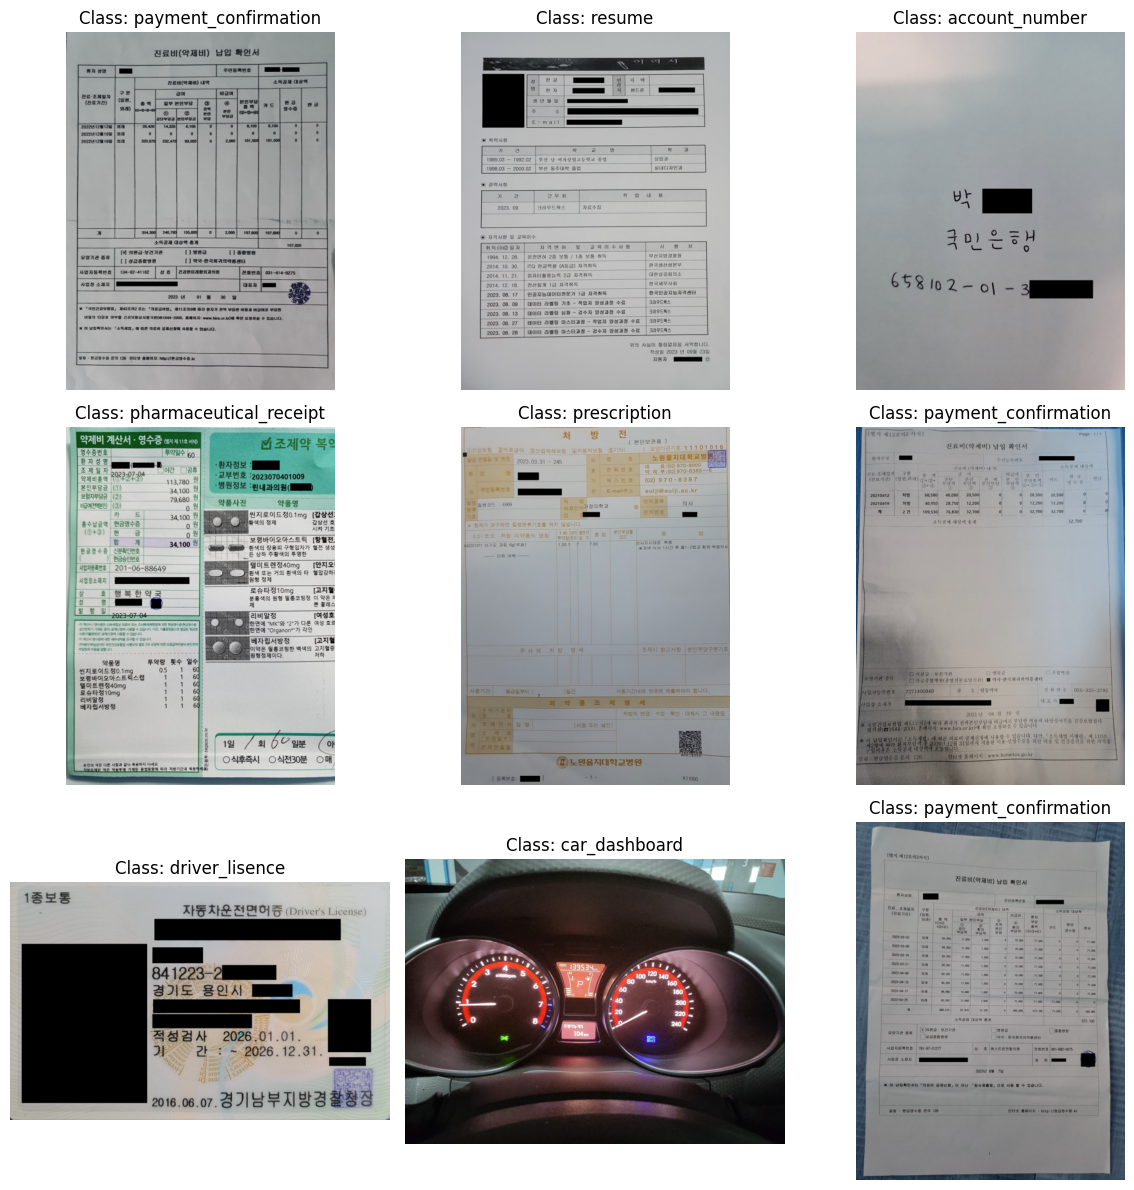

In [5]:
# 랜덤하게 9개의 인덱스 선택
num_images = 9
random_indices = random.sample(range(len(image_files)), num_images)
# 이미지와 라벨 시각화
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    # 이미지 파일 경로
    image_path = os.path.join(image_folder_path, image_files[idx])
    
    # 이미지 열기
    img = Image.open(image_path)
    
    # 이미지 시각화
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    # 분류 코드에서 클래스 이름으로 변환하여 표시
    class_name = target_to_classname[labels[idx]]
    axes[row, col].set_title(f"Class: {class_name}")

plt.tight_layout()
plt.show()

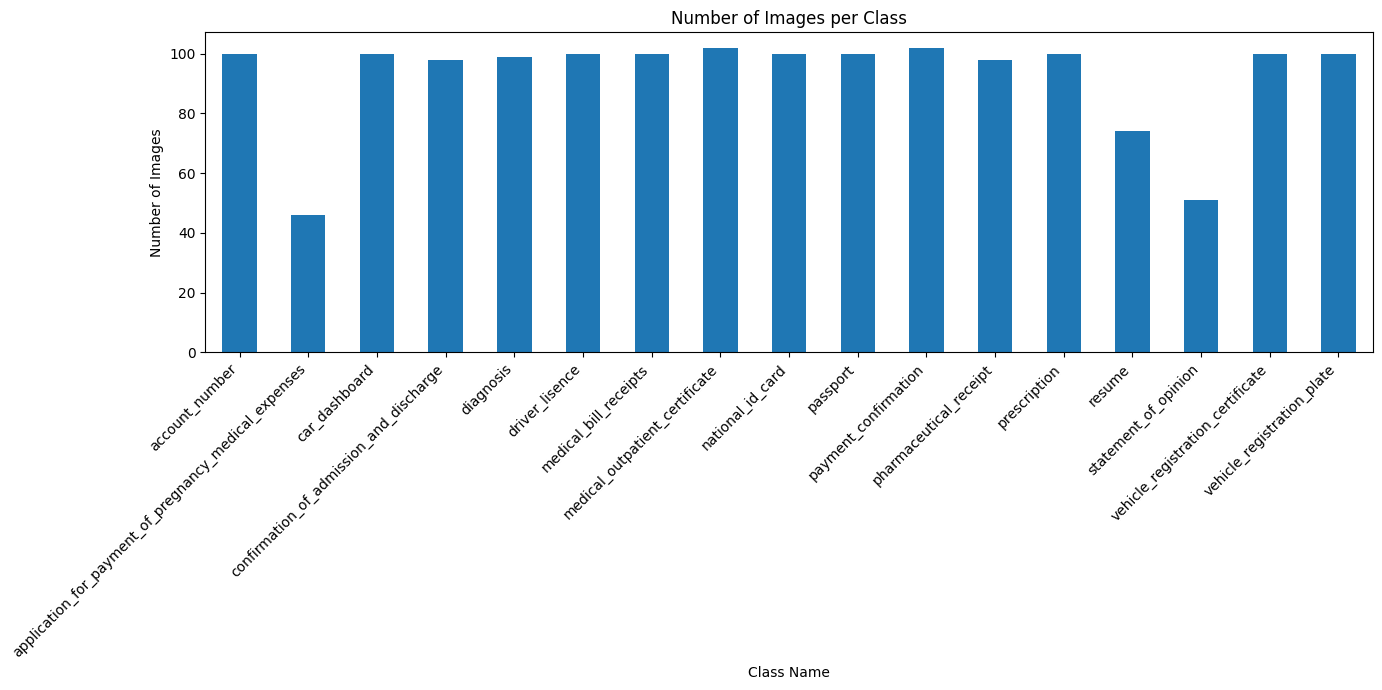

In [6]:
# 클래스 이름을 가진 데이터프레임 생성
train_df['class_name'] = train_df['target'].map(target_to_classname)

# 클래스별 이미지 수 계산
class_counts = train_df['class_name'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(14, 7))
class_counts.plot(kind='bar')
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 이미지 확인 코드

In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 이미지 인덱스 초기화 (범위: 943 ~ 1256)
current_index = widgets.IntText(value=248, description='Index:')

# '다음' 버튼 생성
button = widgets.Button(description="Next Image")

# 이미지를 표시할 Output 위젯 생성
image_output = widgets.Output()

# 이미지와 라벨 시각화 함수
def show_image(index):
    # 이전 출력 지우기
    image_output.clear_output(wait=True)
    
    # 인덱스가 범위 내에 있는지 확인
    # if index < 248 or index > 1256:
    #     with image_output:
    #         print("Index out of range. Please enter an index between 943 and 1256.")
    #     return
    
    # 이미지 경로와 클래스 이름 가져오기
    image_path = os.path.join(image_folder_path, image_files[index])
    class_name = target_to_classname[labels[index]]
    
    # 이미지 열기
    img = Image.open(image_path)
    
    # 이미지 시각화
    with image_output:
        plt.figure(figsize=(10, 10))  # 이미지를 크게 표시
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Class: {class_name}")
        plt.show()

# 버튼 클릭 이벤트 핸들러
def on_button_clicked(b):
    current_index.value += 1
    if current_index.value > 1256:
        current_index.value = 1  # 리스트의 끝에 도달하면 처음으로
    show_image(current_index.value)

# 버튼 클릭 이벤트 연결
button.on_click(on_button_clicked)

# 버튼과 인덱스 위젯을 수평으로 정렬
controls = widgets.HBox([button, current_index])

# 컨트롤과 이미지 출력을 수직으로 정렬
ui = widgets.VBox([controls, image_output])

# UI 표시
display(ui)

# 처음 이미지 표시
show_image(current_index.value)

# OCR Test

In [14]:
import cv2
import numpy as np
import os
import re
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image
from paddleocr import PaddleOCR

# PaddleOCR의 로깅 레벨을 ERROR로 설정하여 디버그 메시지 숨기기
logging.getLogger("paddleocr").setLevel(logging.ERROR)

# PaddleOCR 초기화
ocr = PaddleOCR(use_angle_cls=True, lang="korean", use_gpu=False, show_log=False)

# 간단한 한글/영어 사전 (예시 사전)
dictionary = set(["예시", "사전", "단어", "목록", "example", "dictionary", "word", "list"])

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def segment_image(image_path):
    image = preprocess_image(image_path)
    if image is None:
        return []
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [(image[y:y+h, x:x+w], (x, y, w, h)) 
            for contour in contours 
            for x, y, w, h in [cv2.boundingRect(contour)] 
            if w > 30 and h > 30]

def extract_text_from_segments(image_path, segments):
    original_image = cv2.imread(image_path)
    if original_image is None:
        return ""
    texts = []
    for segment, (x, y, w, h) in segments:
        roi = original_image[y:y+h, x:x+w]
        if roi.size == 0:
            continue
        result = ocr.ocr(roi, cls=True)
        texts.extend(item[1][0] for line in result if line for item in line if isinstance(item, list) and len(item) > 1)
    return ' '.join(texts)

def post_process_text(text):
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s.?!,]', '', text)
    return re.sub(r'\.{2,}', '.', text)

def filter_meaningful_words(text):
    words = text.split()
    meaningful_words = [word for word in words if word.lower() in dictionary]
    return ' '.join(meaningful_words)

def process_image(img_path):
    segments = segment_image(img_path)
    if not segments:
        return "", 0, [], ""
    text = extract_text_from_segments(img_path, segments)
    text = post_process_text(text)
    word_count = len(text.split())
    meaningful_text = filter_meaningful_words(text)
    return text, word_count, segments, meaningful_text

# UI 관련 위젯 초기화
current_index = widgets.IntText(value=0, description='Index:')
button = widgets.Button(description="Next Image")
status_label = widgets.Label(value="Ready")
image_output = widgets.Output()

processing = False

def show_image(index):
    global processing
    if processing:
        return

    processing = True
    status_label.value = "Processing..."
    button.disabled = True

    image_output.clear_output(wait=True)
    image_folder_path = '../data/train'
    image_files = sorted([f for f in os.listdir(image_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if index < 0 or index >= len(image_files):
        with image_output:
            print("Index out of range. Please enter a valid index.")
        processing = False
        status_label.value = "Ready"
        button.disabled = False
        return
    
    image_path = os.path.join(image_folder_path, image_files[index])
    
    try:
        img = Image.open(image_path)
    except Exception as e:
        with image_output:
            print(f"Error opening image {image_path}: {str(e)}")
        processing = False
        status_label.value = "Ready"
        button.disabled = False
        return

    text, word_count, segments, meaningful_text = process_image(image_path)
    
    with image_output:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.show()
        
        for i, (segment, (x, y, w, h)) in enumerate(segments):
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(segment, cv2.COLOR_GRAY2RGB))
            plt.axis('off')
            plt.title(f"Segment {i+1}")
            plt.show()
            print(f"Extracted Text from Segment {i+1}: {extract_text_from_segments(image_path, [(segment, (x, y, w, h))])}")

        print(f"Overall Extracted Text: {text}")
        print(f"Word Count: {word_count}")
        print(f"Meaningful Words: {meaningful_text}")

    processing = False
    status_label.value = "Ready"
    button.disabled = False

def on_button_clicked(b):
    if not processing:
        current_index.value += 1
        show_image(current_index.value)

button.on_click(on_button_clicked)

controls = widgets.HBox([button, current_index, status_label])
ui = widgets.VBox([controls, image_output])

display(ui)
show_image(current_index.value)


# 이미지 분석

In [8]:
def analyze_image_sizes(csv_path, image_folder_path):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)
    
    # 이미지 크기 저장을 위한 리스트
    widths = []
    heights = []
    
    # CSV 파일의 첫 번째 열을 이미지 파일명으로 가정
    image_column = df.columns[0]
    
    # 모든 이미지의 크기 수집
    for image_file in df[image_column]:
        image_path = os.path.join(image_folder_path, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f"Error loading {image_file}: {e}")
    
    # 이미지 크기 데이터프레임 생성
    return pd.DataFrame({'Width': widths, 'Height': heights})

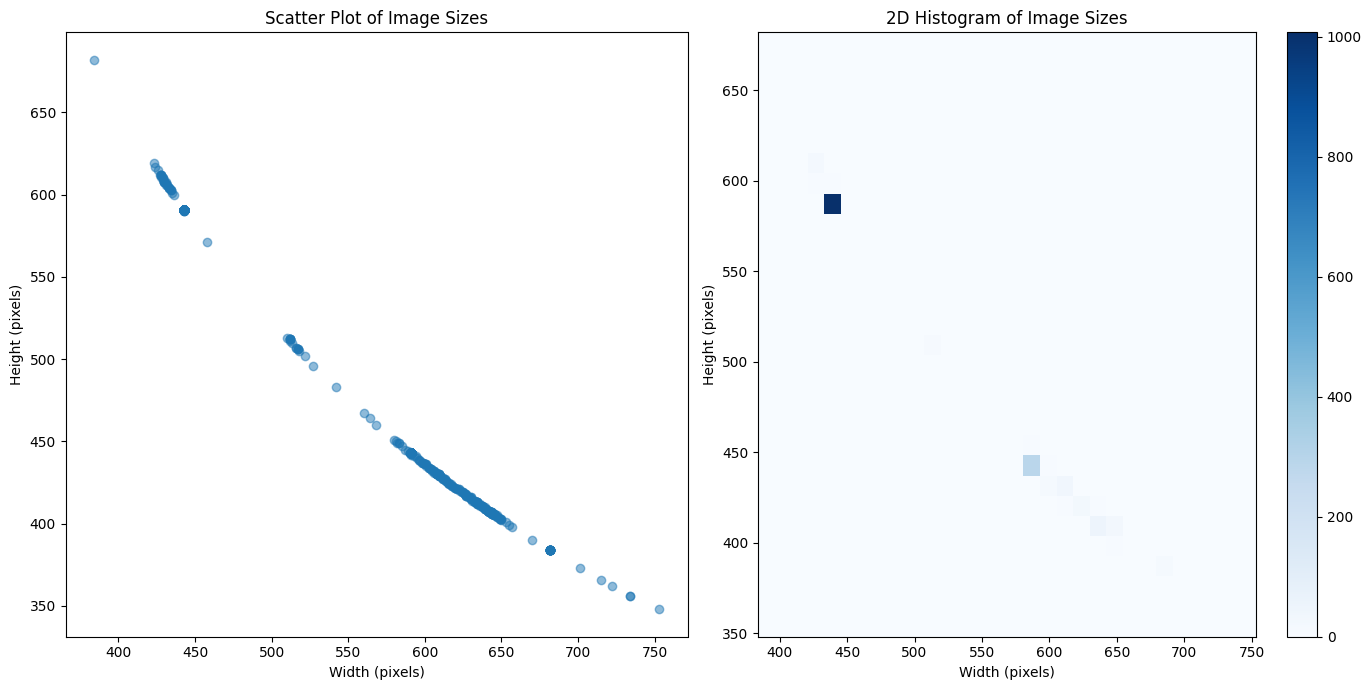

Image Size Statistics:
             Width       Height
count  1570.000000  1570.000000
mean    497.613376   538.169427
std      79.370316    76.074772
min     384.000000   348.000000
25%     443.000000   443.000000
50%     443.000000   591.000000
75%     591.000000   591.000000
max     753.000000   682.000000

Image with the largest width:
Width: 753 pixels, Height: 348 pixels

Image with the largest height:
Width: 384 pixels, Height: 682 pixels

Image with the largest area:
Width: 512 pixels, Height: 512 pixels
Area: 262144 square pixels

Image Width Distribution:
Width
384    1
423    1
424    1
426    1
427    1
      ..
701    1
715    1
722    1
734    2
753    1
Name: count, Length: 102, dtype: int64

Image Height Distribution:
Height
348    1
356    2
362    1
366    1
373    1
      ..
612    5
615    1
617    1
619    1
682    1
Name: count, Length: 89, dtype: int64


In [9]:
image_folder_path = '../data/train/'
test_csv_path = '../data/train_correct_labeling.csv'

# 이미지 크기 분석
image_sizes = analyze_image_sizes(test_csv_path, image_folder_path)

# 이미지 크기 시각화
plt.figure(figsize=(14, 7))

# 산점도
plt.subplot(1, 2, 1)
plt.scatter(image_sizes['Width'], image_sizes['Height'], alpha=0.5)
plt.title('Scatter Plot of Image Sizes')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# 히스토그램
plt.subplot(1, 2, 2)
plt.hist2d(image_sizes['Width'], image_sizes['Height'], bins=30, cmap='Blues')
plt.colorbar()
plt.title('2D Histogram of Image Sizes')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

# 기본 통계 출력
print("Image Size Statistics:")
print(image_sizes.describe())

# 가장 큰 width, height, area를 가진 이미지 찾기
max_width_image = image_sizes.loc[image_sizes['Width'].idxmax()]
max_height_image = image_sizes.loc[image_sizes['Height'].idxmax()]
image_sizes['Area'] = image_sizes['Width'] * image_sizes['Height']
max_area_image = image_sizes.loc[image_sizes['Area'].idxmax()]

print("\nImage with the largest width:")
print(f"Width: {max_width_image['Width']} pixels, Height: {max_width_image['Height']} pixels")

print("\nImage with the largest height:")
print(f"Width: {max_height_image['Width']} pixels, Height: {max_height_image['Height']} pixels")

print("\nImage with the largest area:")
print(f"Width: {max_area_image['Width']} pixels, Height: {max_area_image['Height']} pixels")
print(f"Area: {max_area_image['Area']} square pixels")

# 이미지 크기 분포 출력
print("\nImage Width Distribution:")
print(image_sizes['Width'].value_counts().sort_index())
print("\nImage Height Distribution:")
print(image_sizes['Height'].value_counts().sort_index())

Image Size Statistics:
             Width       Height
count  3140.000000  3140.000000
mean    517.085032   518.556369
std      79.846556    79.803967
min     343.000000   343.000000
25%     443.000000   443.000000
50%     489.000000   535.500000
75%     591.000000   591.000000
max     763.000000   763.000000

Image with the largest width:
Width: 763 pixels, Height: 343 pixels

Image with the largest height:
Width: 343 pixels, Height: 763 pixels

Image with the largest area:
Width: 512 pixels, Height: 512 pixels
Area: 262144 square pixels


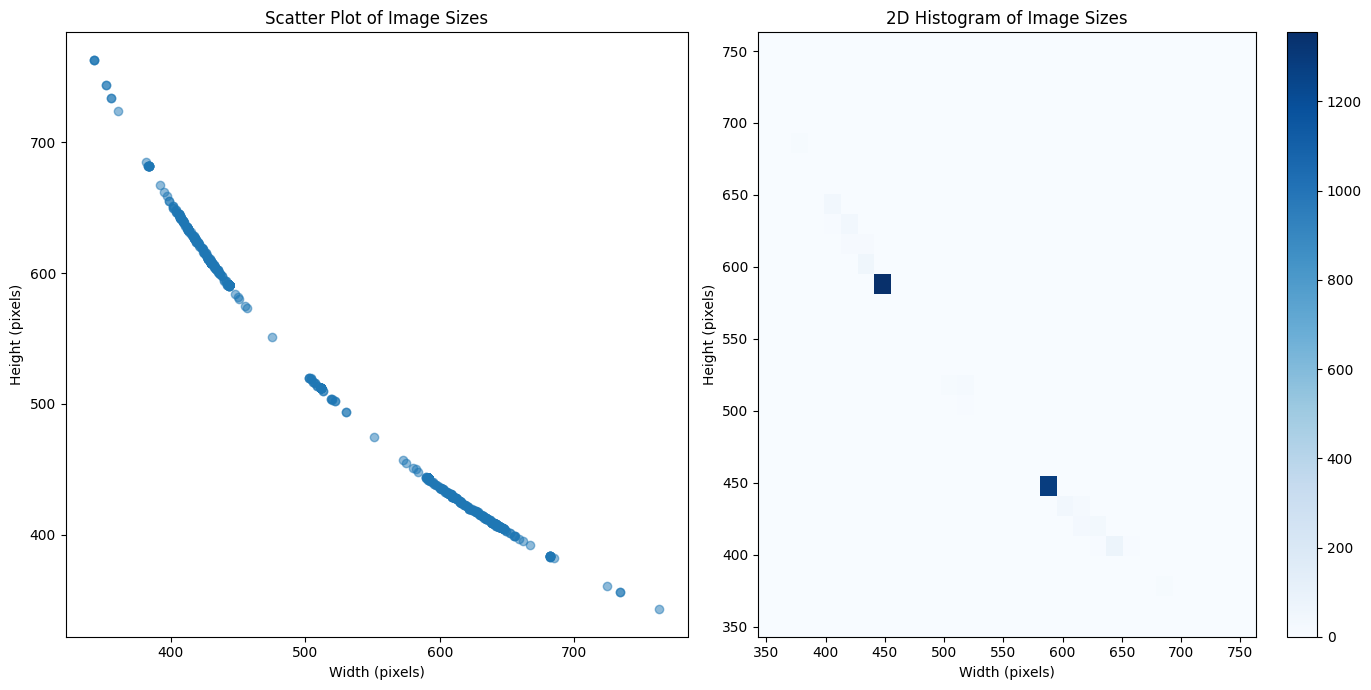


Image Width Distribution:
Width
343     3
352     2
356     2
361     1
382     1
       ..
682    11
685     1
724     1
734     2
763     1
Name: count, Length: 142, dtype: int64

Image Height Distribution:
Height
343    1
356    2
361    1
382    1
383    3
      ..
685    1
724    1
734    2
744    2
763    3
Name: count, Length: 142, dtype: int64


In [10]:
# test data 의 이미지 크기 확인

image_folder_path = '../data/test/'
    
# CSV 파일 경로
test_csv_path = '../data/sample_submission.csv'  # 예시 경로, 실제 경로로 수정 필요

# 이미지 크기 분석
image_sizes = analyze_image_sizes(test_csv_path, image_folder_path)

# 기본 통계 출력
print("Image Size Statistics:")
print(image_sizes.describe())

# 가장 큰 width, height, area를 가진 이미지 찾기
max_width_image = image_sizes.loc[image_sizes['Width'].idxmax()]
max_height_image = image_sizes.loc[image_sizes['Height'].idxmax()]
image_sizes['Area'] = image_sizes['Width'] * image_sizes['Height']
max_area_image = image_sizes.loc[image_sizes['Area'].idxmax()]

print("\nImage with the largest width:")
print(f"Width: {max_width_image['Width']} pixels, Height: {max_width_image['Height']} pixels")

print("\nImage with the largest height:")
print(f"Width: {max_height_image['Width']} pixels, Height: {max_height_image['Height']} pixels")

print("\nImage with the largest area:")
print(f"Width: {max_area_image['Width']} pixels, Height: {max_area_image['Height']} pixels")
print(f"Area: {max_area_image['Area']} square pixels")

# 이미지 크기 시각화
plt.figure(figsize=(14, 7))

# 산점도
plt.subplot(1, 2, 1)
plt.scatter(image_sizes['Width'], image_sizes['Height'], alpha=0.5)
plt.title('Scatter Plot of Image Sizes')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# 히스토그램
plt.subplot(1, 2, 2)
plt.hist2d(image_sizes['Width'], image_sizes['Height'], bins=30, cmap='Blues')
plt.colorbar()
plt.title('2D Histogram of Image Sizes')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

# 이미지 크기 분포 출력
print("\nImage Width Distribution:")
print(image_sizes['Width'].value_counts().sort_index())
print("\nImage Height Distribution:")
print(image_sizes['Height'].value_counts().sort_index())

## 이미지 사이즈를 같은 사이즈로 전처리.

In [14]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_image_for_ocr(image_path, output_size, background_color=(255, 255, 255)):
    # 이미지 읽기 (PIL 사용)
    image = Image.open(image_path)
    
    # 리사이즈
    original_size = image.size
    ratio = min(output_size / original_size[0], output_size / original_size[1])
    new_size = tuple([int(x * ratio) for x in original_size])
    resized_image = image.resize(new_size, Image.BILINEAR)
    
    # 정사각형 백그라운드 이미지 생성 (백그라운드 컬러: 흰색)
    new_image = Image.new("RGB", (output_size, output_size), background_color)
    
    # 리사이즈된 이미지 중앙에 배치
    paste_position = ((output_size - new_size[0]) // 2, (output_size - new_size[1]) // 2)
    new_image.paste(resized_image, paste_position)
    
    # 이미지 대비 조정 및 샤프닝
    enhancer = ImageEnhance.Contrast(new_image)
    new_image = enhancer.enhance(1.2)  # 대비 약간 증가
    enhancer = ImageEnhance.Sharpness(new_image)
    new_image = enhancer.enhance(1.2)  # 선명도 약간 증가
    
    return new_image

def process_dataset(csv_path, input_folder, output_folder, output_size):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)
    image_column = df.columns[0]  # 첫 번째 열을 이미지 파일명으로 가정
    
    # 출력 폴더 생성
    os.makedirs(output_folder, exist_ok=True)
    
    # 모든 이미지에 대해 전처리 적용
    for index, row in df.iterrows():
        image_file = row[image_column]
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)  # 'preprocessed_' 접두사 제거
        
        try:
            # 전처리 함수 호출
            preprocessed_image = preprocess_image_for_ocr(input_path, output_size, background_color=(255, 255, 255))
            
            # 전처리된 이미지 저장
            preprocessed_image.save(output_path, 'JPEG', quality=95, optimize=True)
            print(f"Preprocessed: {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
    
    print("Preprocessing completed.")

def analyze_image_sizes(folder_path):
    widths = []
    heights = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
    
    return pd.DataFrame({'Width': widths, 'Height': heights})


IMAGE_SIZE = 384
input_folder = '../data/train/'
output_folder = '../data/train_preprocessed/'
csv_path = '../data/train_correct_labeling.csv'

# 데이터셋 전처리
process_dataset(csv_path, input_folder, output_folder, IMAGE_SIZE)

Preprocessed: 002f99746285dfdd.jpg
Preprocessed: 008ccd231e1fea5d.jpg
Preprocessed: 008f5911bfda7695.jpg
Preprocessed: 009235e4c9c07af5.jpg
Preprocessed: 00b2f44967580c74.jpg
Preprocessed: 00cfa88ce8973dea.jpg
Preprocessed: 00ec594b7cc89183.jpg
Preprocessed: 00f59b12e9e08f29.jpg
Preprocessed: 00fdc02d9b552fe8.jpg
Preprocessed: 012913977fd1d980.jpg
Preprocessed: 0134204c33c8d37c.jpg
Preprocessed: 0143de5f1099427d.jpg
Preprocessed: 01af3d4c58c8530f.jpg
Preprocessed: 01c0b97e1492b220.jpg
Preprocessed: 024fe478044874ab.jpg
Preprocessed: 0250ee8107091ade.jpg
Preprocessed: 02533d35fe935981.jpg
Preprocessed: 026817f3f9434f5b.jpg
Preprocessed: 02ab86a5d5a979cc.jpg
Preprocessed: 02d404271e4965fa.jpg
Preprocessed: 02dad82a9420ae86.jpg
Preprocessed: 02e1538cef751c7d.jpg
Preprocessed: 02ebb92c43006832.jpg
Preprocessed: 03075ea3046d4459.jpg
Preprocessed: 03084c1b03921a99.jpg
Preprocessed: 03636653282bb56c.jpg
Preprocessed: 03648b6855b9f8c1.jpg
Preprocessed: 03ce6a0a86939c04.jpg
Preprocessed: 040073

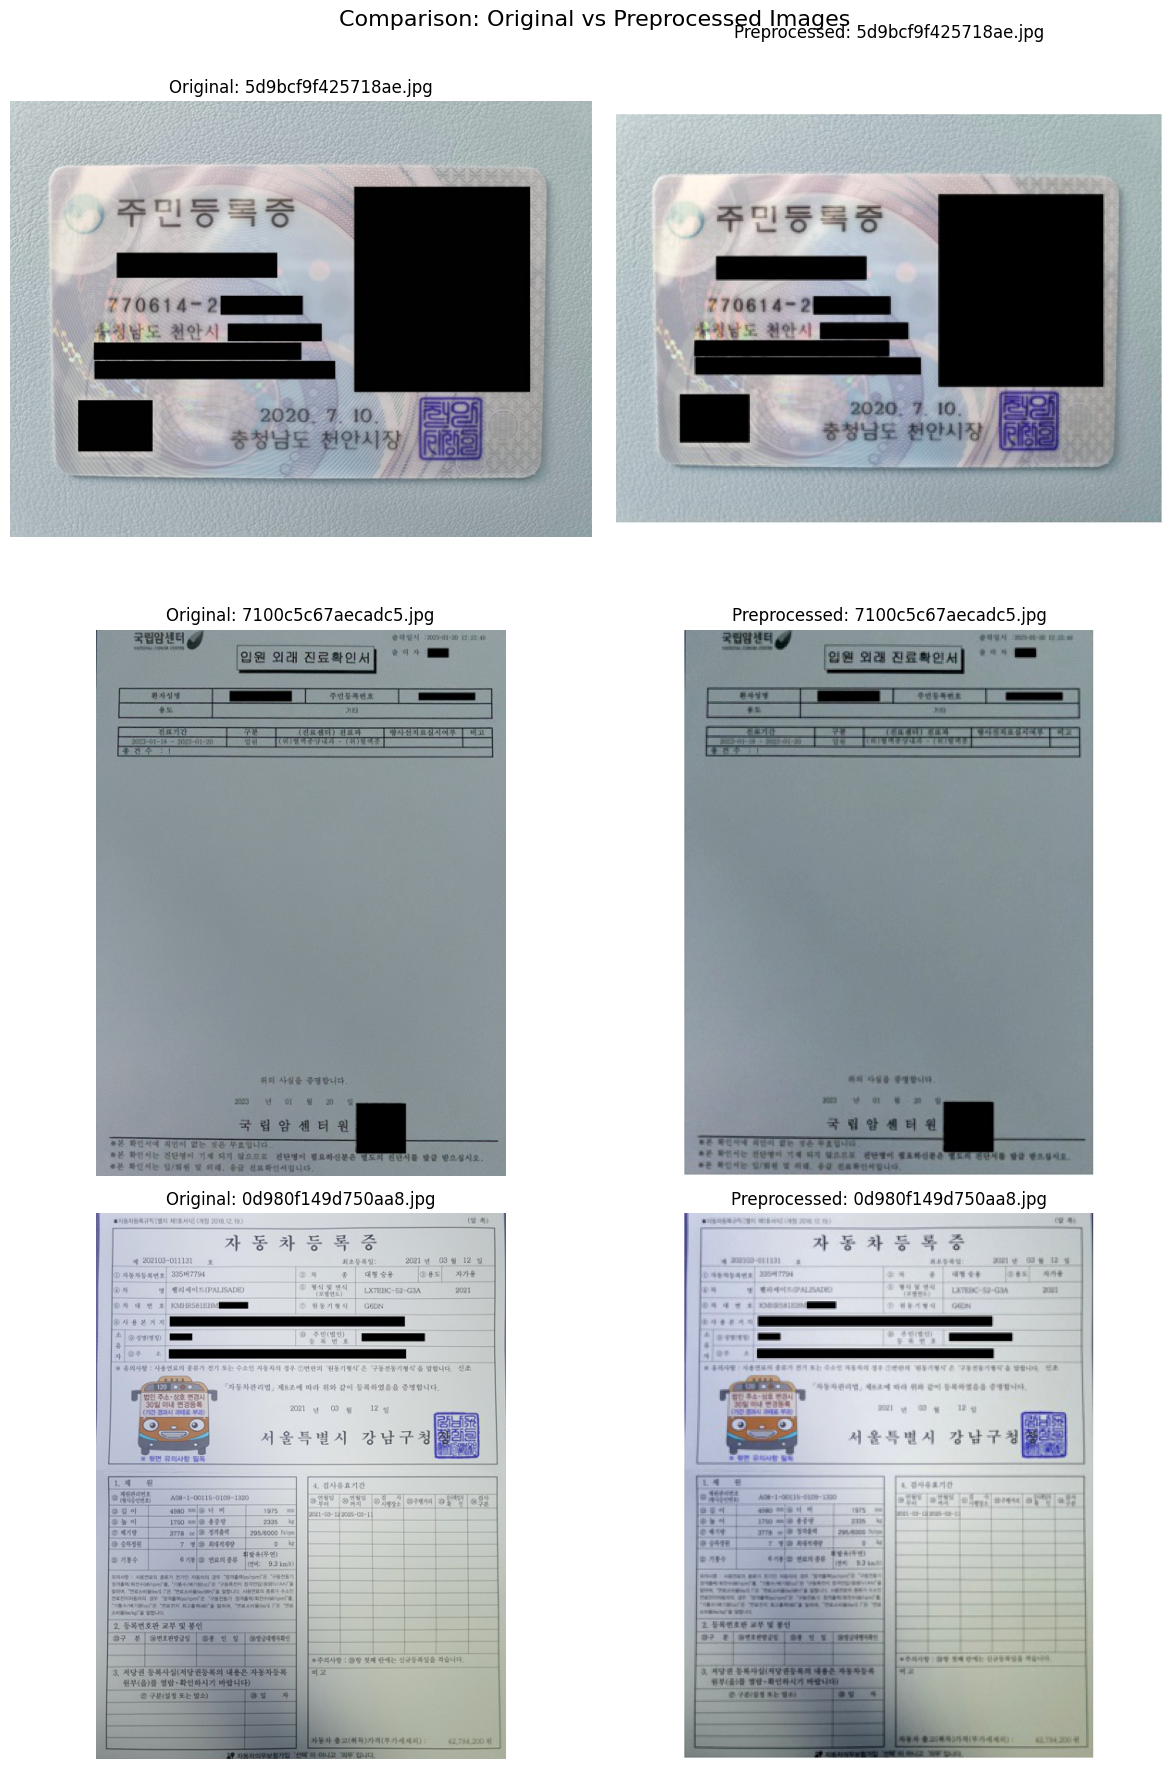

In [15]:
def compare_images(input_folder, output_folder, csv_path, n_samples=3):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)
    image_column = df.columns[0]  # 첫 번째 열을 이미지 파일명으로 가정
    
    # 랜덤하게 n_samples 개의 이미지 선택
    sample_images = random.sample(df[image_column].tolist(), n_samples)
    
    # 이미지 비교 및 시각화
    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 6*n_samples))
    fig.suptitle("Comparison: Original vs Preprocessed Images", fontsize=16)
    
    for i, image_file in enumerate(sample_images):
        # 원본 이미지 로드
        original_path = os.path.join(input_folder, image_file)
        original_img = Image.open(original_path)
        
        # 전처리된 이미지 로드
        preprocessed_path = os.path.join(output_folder, image_file)  # 'preprocessed_' 접두사 제거
        preprocessed_img = Image.open(preprocessed_path)
        
        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original: {image_file}")
        axes[i, 0].axis('off')
        
        # 전처리된 이미지 표시
        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed: {image_file}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


compare_images(input_folder, output_folder, csv_path, n_samples=3)

## test data 전처리

In [16]:
IMAGE_SIZE = 384
input_folder = '../data/test/'
output_folder = '../data/test_preprocessed/'
csv_path = '../data/sample_submission.csv'

# 데이터셋 전처리
process_dataset(csv_path, input_folder, output_folder, IMAGE_SIZE)

Preprocessed: 0008fdb22ddce0ce.jpg
Preprocessed: 00091bffdffd83de.jpg
Preprocessed: 00396fbc1f6cc21d.jpg
Preprocessed: 00471f8038d9c4b6.jpg
Preprocessed: 00901f504008d884.jpg
Preprocessed: 009b22decbc7220c.jpg
Preprocessed: 00b33e0ee6d59427.jpg
Preprocessed: 00bbdcfbbdb3e131.jpg
Preprocessed: 00c03047e0fbef40.jpg
Preprocessed: 00c0dabb63ca7a16.jpg
Preprocessed: 00dcea90f63ad630.jpg
Preprocessed: 00e15da96484eb94.jpg
Preprocessed: 00f5784903a39fdd.jpg
Preprocessed: 0111a6728e9f8a73.jpg
Preprocessed: 0114a887a2c2e4ca.jpg
Preprocessed: 01385f22f2490868.jpg
Preprocessed: 0145dd3d1cd090ae.jpg
Preprocessed: 016240faa186d24d.jpg
Preprocessed: 016b0c00cdf93e0a.jpg
Preprocessed: 017ba667291b53c6.jpg
Preprocessed: 017e5da799e1637c.jpg
Preprocessed: 0182bffa56bdd844.jpg
Preprocessed: 019ed42bb4c2caa9.jpg
Preprocessed: 01bd84a54be54b8b.jpg
Preprocessed: 01c918594307c6f2.jpg
Preprocessed: 01ebd05a14e10618.jpg
Preprocessed: 020740b55bbc329e.jpg
Preprocessed: 021e7c8d9dc19021.jpg
Preprocessed: 0298c2